# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">Insurance Price Prediction</p>

![](https://online.maryville.edu/wp-content/uploads/sites/97/2020/10/MVU-MSDSCI-2020-Q1-Skyscraper-Predictive-Analytics-in-Insurance-Types-Tools-and-the-Future-header-v1.jpg)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import math
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.impute import SimpleImputer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">🚀 Introduction to the Dataset 🚀</p>

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s4e12/sample_submission.csv')

# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">🌟 Overview of Variables and Types</p>

In [3]:
train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1200000.0,599999.500000,346410.305851,0.000000,299999.750000,599999.500000,899999.250000,1.199999e+06
Age,1181295.0,41.145563,13.539950,18.000000,30.000000,41.000000,53.000000,6.400000e+01
Annual Income,1155051.0,32745.217777,32179.506124,1.000000,8001.000000,23911.000000,44634.000000,1.499970e+05
Number of Dependents,1090328.0,2.009934,1.417338,0.000000,1.000000,2.000000,3.000000,4.000000e+00
Health Score,1125924.0,25.613908,12.203462,2.012237,15.918959,24.578648,34.527209,5.897591e+01
Previous Claims,835971.0,1.002689,0.982840,0.000000,0.000000,1.000000,2.000000,9.000000e+00
Vehicle Age,1199994.0,9.569889,5.776189,0.000000,5.000000,10.000000,15.000000,1.900000e+01
Credit Score,1062118.0,592.924350,149.981945,300.000000,468.000000,595.000000,721.000000,8.490000e+02
Insurance Duration,1199999.0,5.018219,2.594331,1.000000,3.000000,5.000000,7.000000,9.000000e+00
Premium Amount,1200000.0,1102.544822,864.998859,20.000000,514.000000,872.000000,1509.000000,4.999000e+03


In [6]:
print("Null Values in Train Data:")
train.isnull().sum()

Null Values in Train Data:


id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

In [7]:
print("Duplicated Rows in Train Data:",train.duplicated().sum())
print('-'*30)
print("Number of Rows:",train.shape[0])
print("-"*30)
print("Number of Column:",train.shape[1])

Duplicated Rows in Train Data: 0
------------------------------
Number of Rows: 1200000
------------------------------
Number of Column: 21


In [8]:
numerical_column_names =train.select_dtypes(include=['number']).columns
print("Numerical Column Names:", numerical_column_names.tolist())

Numerical Column Names: ['id', 'Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Premium Amount']


In [9]:
object_column_names = train.select_dtypes(include=['object']).columns
print("Object Column Names:", object_column_names.tolist())

Object Column Names: ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Policy Start Date', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']


In [10]:
print("Unique Value in Train Data:")
train.nunique()

Unique Value in Train Data:


id                      1200000
Age                          47
Gender                        2
Annual Income             88593
Marital Status                3
Number of Dependents          5
Education Level               4
Occupation                    3
Health Score             532657
Location                      3
Policy Type                   3
Previous Claims              10
Vehicle Age                  20
Credit Score                550
Insurance Duration            9
Policy Start Date        167381
Customer Feedback             3
Smoking Status                2
Exercise Frequency            4
Property Type                 3
Premium Amount             4794
dtype: int64

In [11]:
numerical_column = ['Age', 
                    'Annual Income', 
                    'Number of Dependents',
                    'Health Score',
                    'Previous Claims', 
                    'Vehicle Age',
                    'Credit Score',
                    'Insurance Duration']

In [12]:
object_column = ['Marital Status',
                 'Education Level',
                 'Occupation',
                 'Location', 
                 'Policy Type',
                 'Customer Feedback', 
                 'Exercise Frequency',
                 'Property Type']

In [13]:
print("Unique Values in Categorical Data:")
for column in object_column:
    unique_values = train[column].unique()  
    print(f"Unique values in '{column}':")
    print(unique_values)
    print() 

Unique Values in Categorical Data:
Unique values in 'Marital Status':
['Married' 'Divorced' 'Single' nan]

Unique values in 'Education Level':
["Bachelor's" "Master's" 'High School' 'PhD']

Unique values in 'Occupation':
['Self-Employed' nan 'Employed' 'Unemployed']

Unique values in 'Location':
['Urban' 'Rural' 'Suburban']

Unique values in 'Policy Type':
['Premium' 'Comprehensive' 'Basic']

Unique values in 'Customer Feedback':
['Poor' 'Average' 'Good' nan]

Unique values in 'Exercise Frequency':
['Weekly' 'Monthly' 'Daily' 'Rarely']

Unique values in 'Property Type':
['House' 'Apartment' 'Condo']



In [14]:
for column in object_column:
    print(f"\nTop value counts in '{column}':\n{train[column].value_counts()}")


Top value counts in 'Marital Status':
Marital Status
Single      395391
Married     394316
Divorced    391764
Name: count, dtype: int64

Top value counts in 'Education Level':
Education Level
Master's       303818
PhD            303507
Bachelor's     303234
High School    289441
Name: count, dtype: int64

Top value counts in 'Occupation':
Occupation
Employed         282750
Self-Employed    282645
Unemployed       276530
Name: count, dtype: int64

Top value counts in 'Location':
Location
Suburban    401542
Rural       400947
Urban       397511
Name: count, dtype: int64

Top value counts in 'Policy Type':
Policy Type
Premium          401846
Comprehensive    399600
Basic            398554
Name: count, dtype: int64

Top value counts in 'Customer Feedback':
Customer Feedback
Average    377905
Poor       375518
Good       368753
Name: count, dtype: int64

Top value counts in 'Exercise Frequency':
Exercise Frequency
Weekly     306179
Monthly    299830
Rarely     299420
Daily      294571
Name

In [15]:
train['Policy Start Date'] = pd.to_datetime(train['Policy Start Date'])

train['Start Year'] = train['Policy Start Date'].dt.year
train['Start Month'] = train['Policy Start Date'].dt.month
train['Start Day'] = train['Policy Start Date'].dt.day

train.drop(columns=['Policy Start Date'], inplace=True)

In [16]:
train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Start Year,Start Month,Start Day
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,372.0,5.0,Poor,No,Weekly,House,2869.0,2023,12,23
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,694.0,2.0,Average,Yes,Monthly,House,1483.0,2023,6,12
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,NaN,3.0,Good,Yes,Weekly,House,567.0,2023,9,30
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,367.0,1.0,Poor,Yes,Daily,Apartment,765.0,2024,6,12
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,598.0,4.0,Poor,Yes,Weekly,House,2022.0,2021,12,1


# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">🏆 Target Variable: Premium Amount</p>

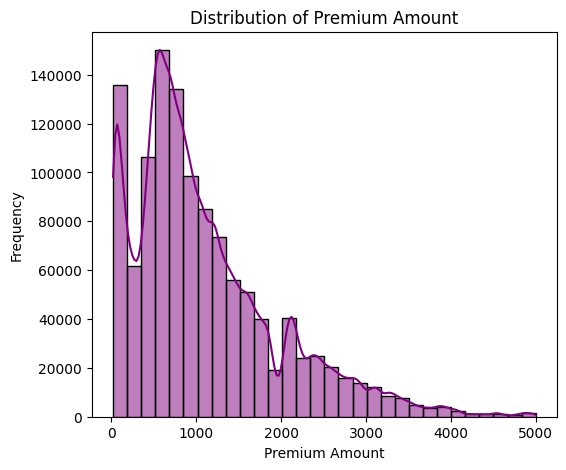

In [17]:
plt.figure(figsize=(6, 5))
sns.histplot(train['Premium Amount'], kde=True, color='purple', bins=30)
plt.title('Distribution of Premium Amount')
plt.xlabel('Premium Amount')
plt.ylabel('Frequency')
plt.show()

# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">🚬 Smoking Status: Sizzle Behind the Smoke! </p>

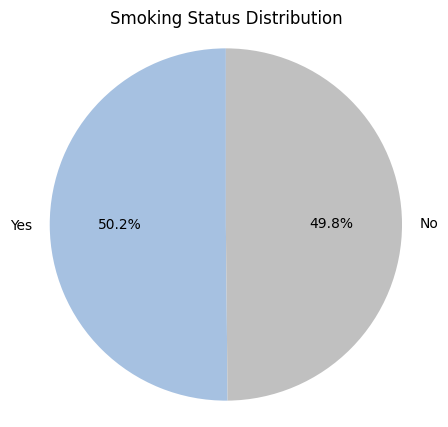

In [18]:
smoking_status_counts = train['Smoking Status'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(smoking_status_counts, labels=smoking_status_counts.index, 
        autopct='%1.1f%%', startangle=90, 
        colors=['#a6c1e1', '#c0c0c0'])  
plt.title('Smoking Status Distribution')
plt.axis('equal')  
plt.show()

# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">🎉✨Gender: The Fabulous Spectrum</p>

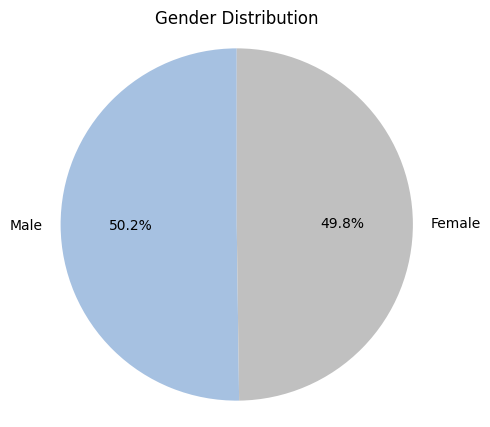

In [19]:
gender_counts = train['Gender'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(gender_counts, labels=gender_counts.index, 
        autopct='%1.1f%%', startangle=90, 
        colors=['#a6c1e1', '#c0c0c0'])  
plt.title('Gender Distribution')
plt.axis('equal')  
plt.show()

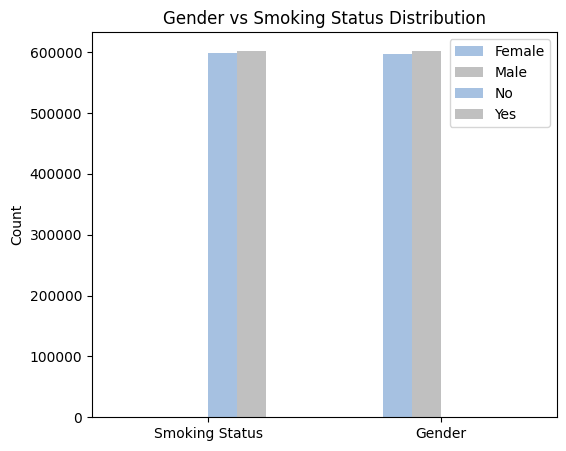

In [20]:
comparison_data = pd.DataFrame({
    'Smoking Status': smoking_status_counts,
    'Gender': gender_counts
}).fillna(0).T 

comparison_data.plot(kind='bar', figsize=(6, 5), color=['#a6c1e1', '#c0c0c0'])
plt.title('Gender vs Smoking Status Distribution')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">🎭 Categorical Variables Distribution</p>

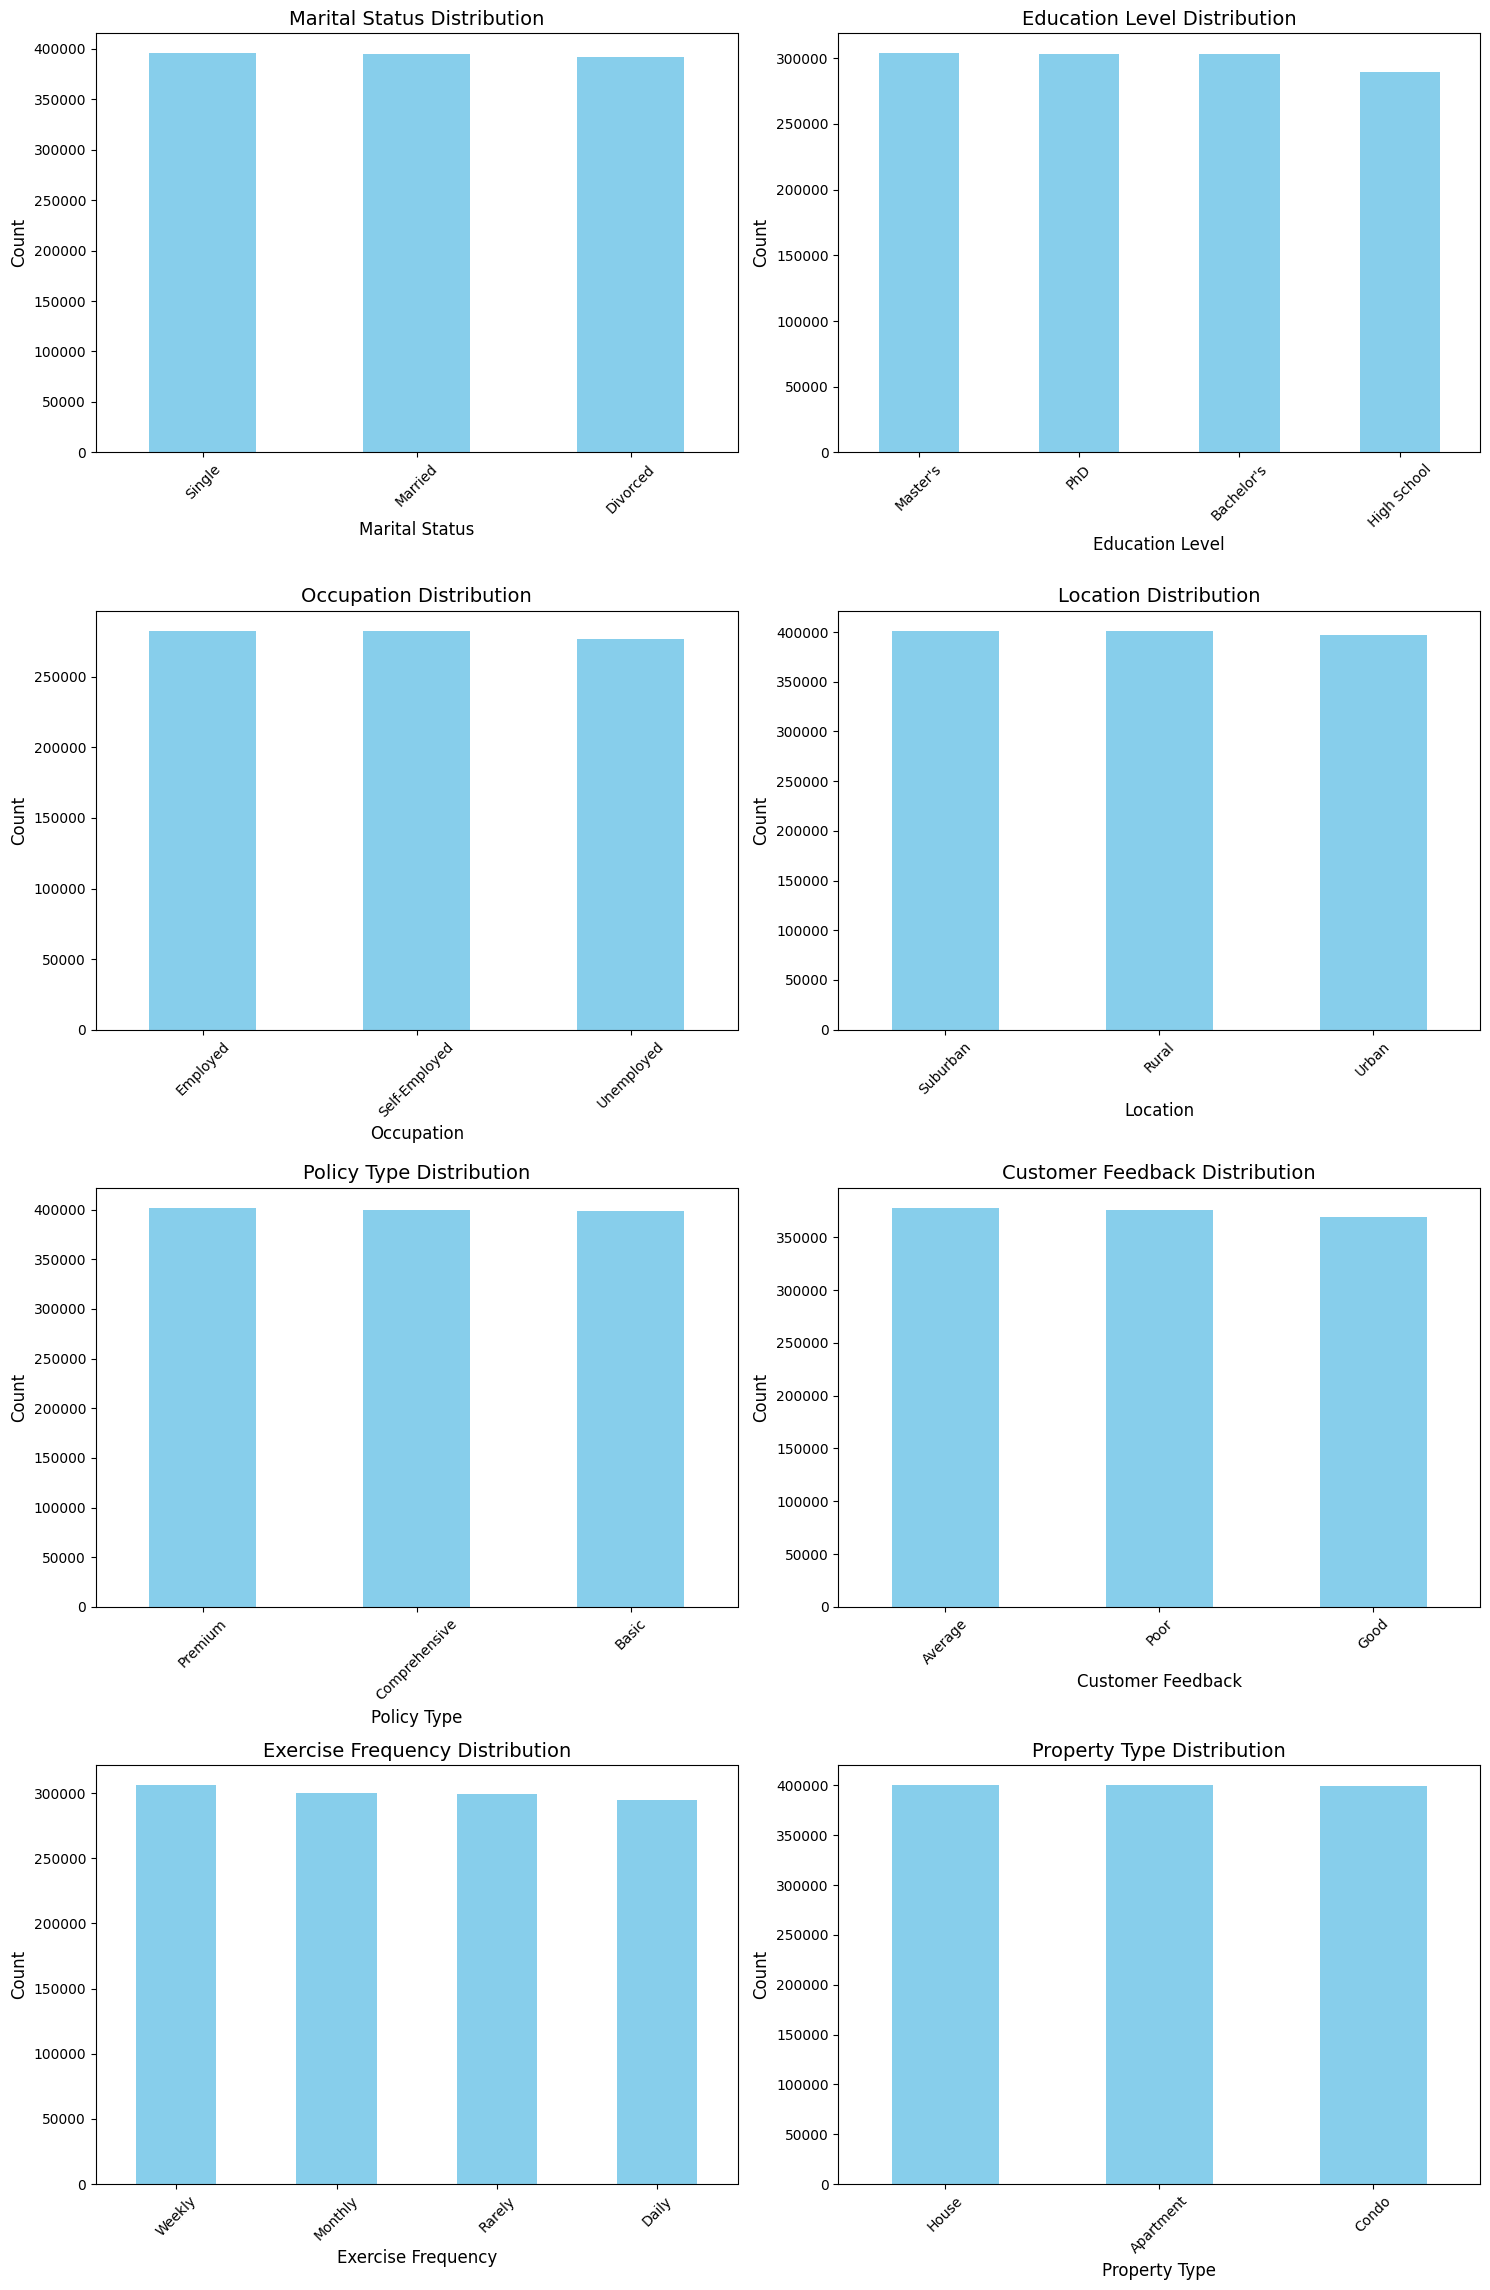

In [21]:
rows, cols = 4, 2

fig, axes = plt.subplots(rows, cols, figsize=(15, 23))
axes = axes.flatten()  

for i, col in enumerate(object_column):
    train[col].value_counts().plot(kind='bar', color='skyblue', ax=axes[i])
    axes[i].set_title(f'{col} Distribution', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

for i in range(len(object_column), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">🔢 Numerical Variables Distribution</p>

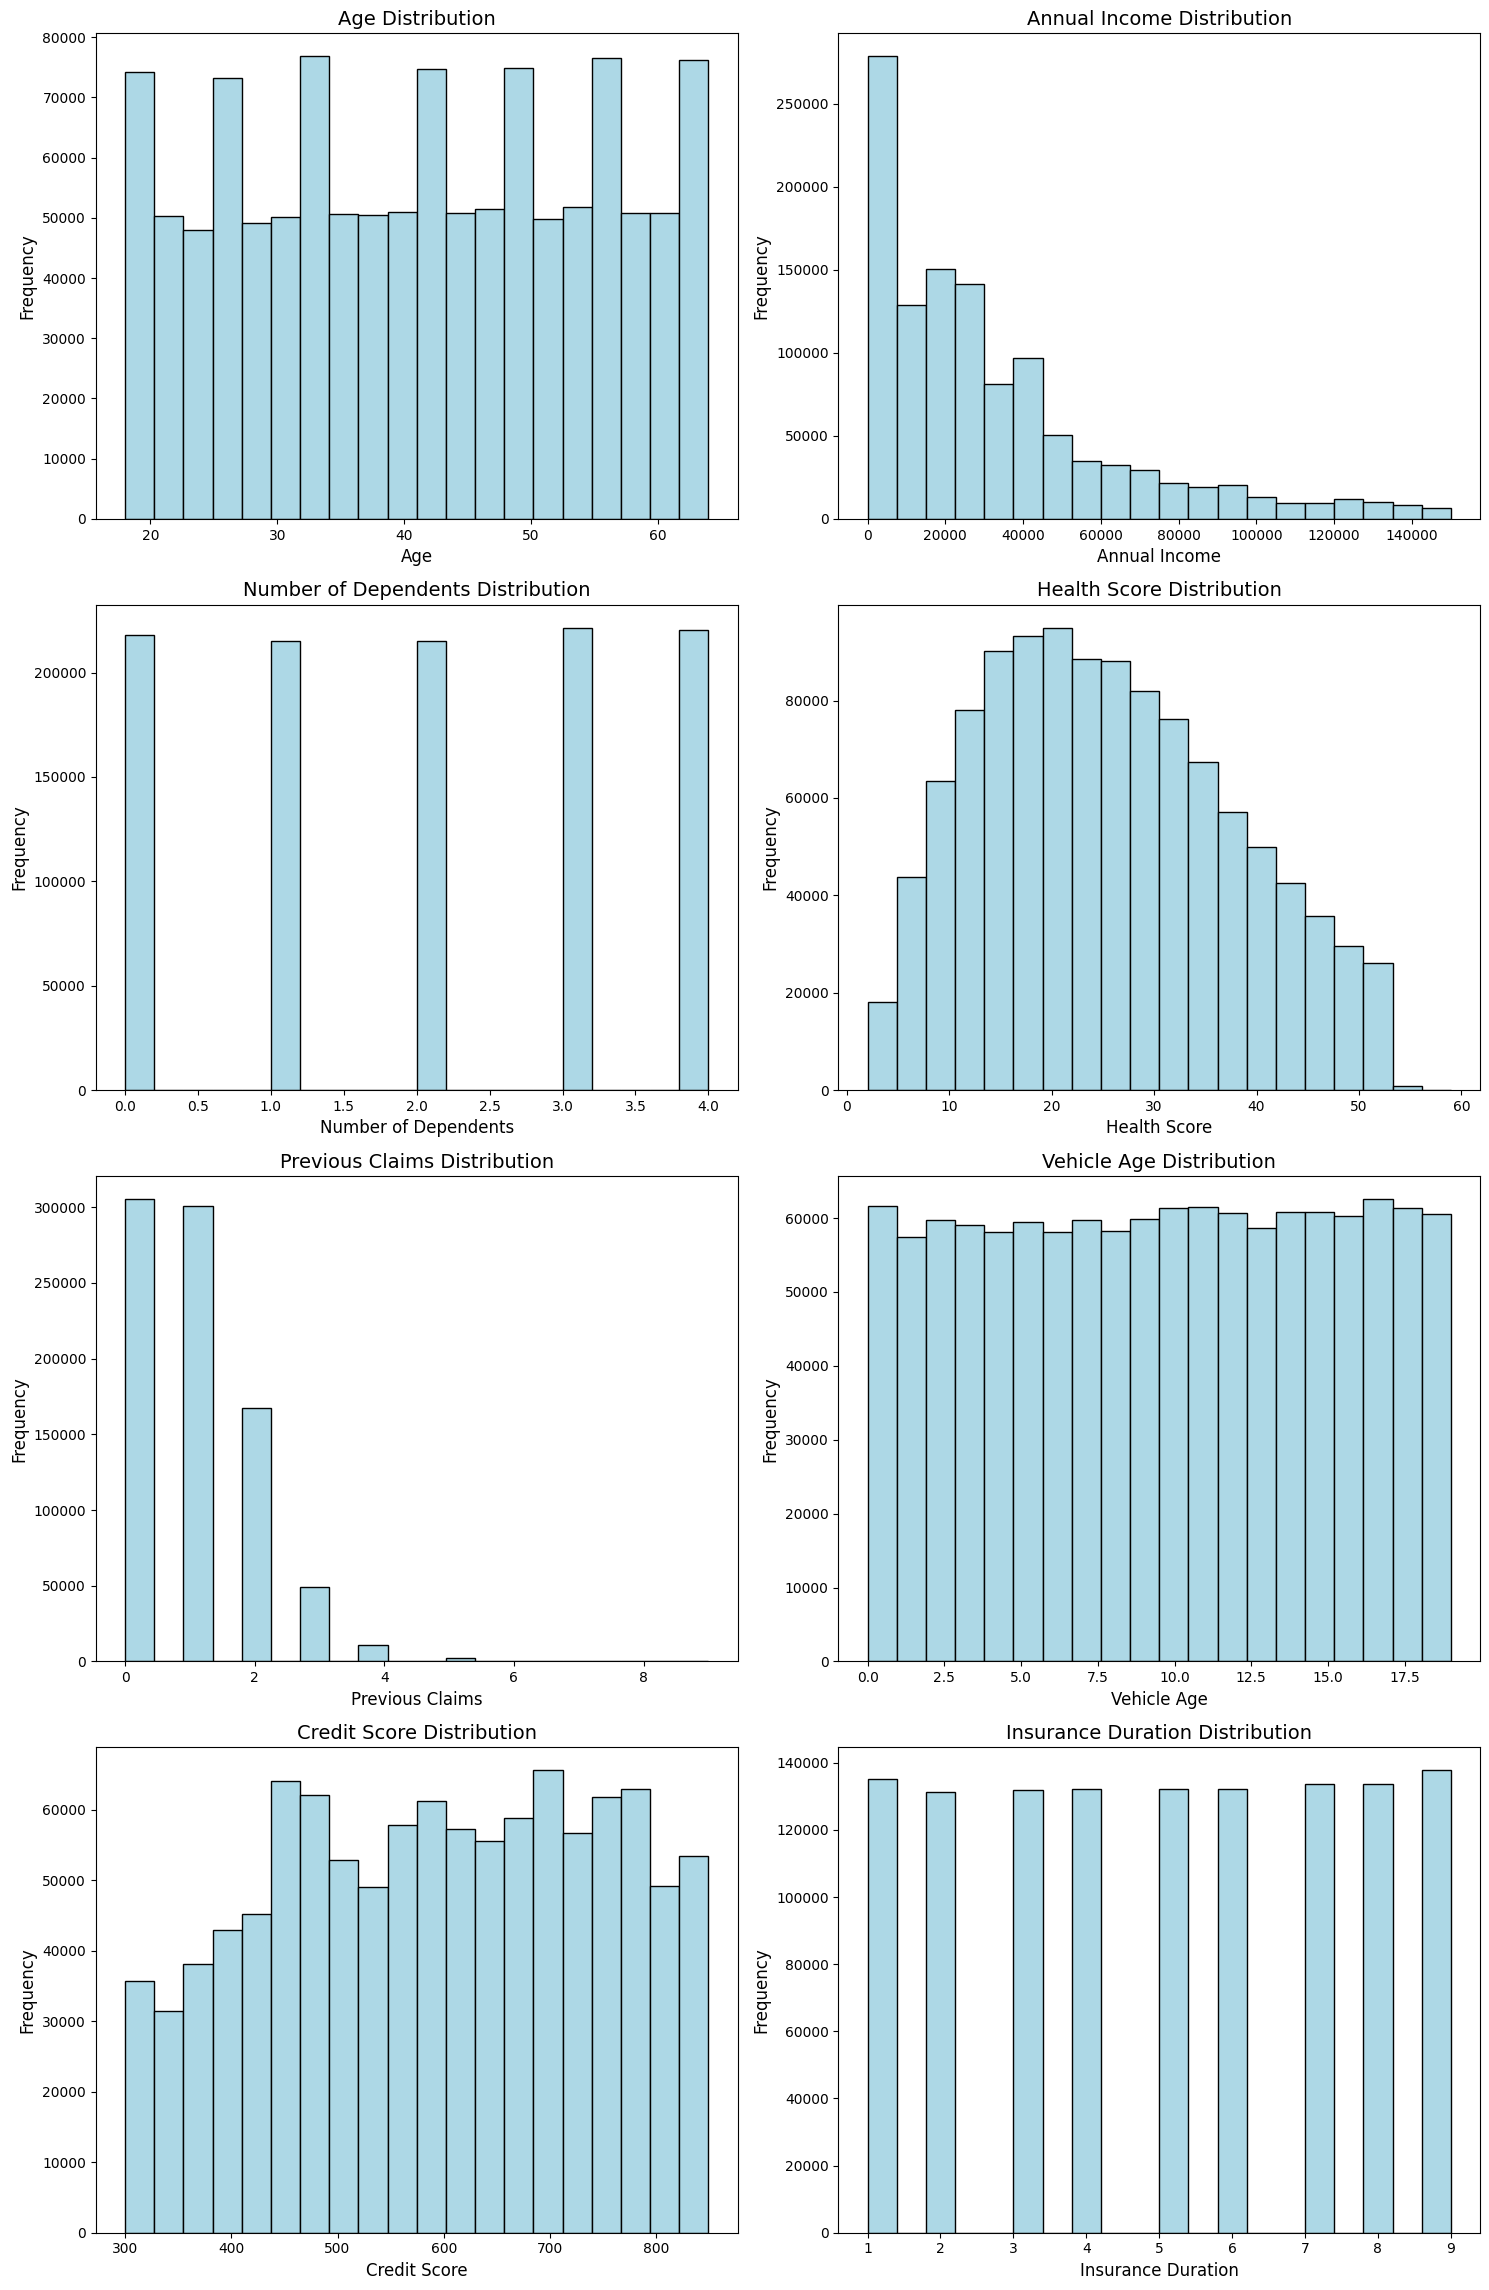

In [22]:
rows, cols = 4, 2

fig, axes = plt.subplots(rows, cols, figsize=(15, 23))
axes = axes.flatten()  

for i, col in enumerate(numerical_column):
    axes[i].hist(train[col], bins=20, color='lightblue', edgecolor='black')
    axes[i].set_title(f'{col} Distribution', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

for i in range(len(numerical_column), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">🎨 Box Plot of Numerical Variables Distribution 🎉</p>

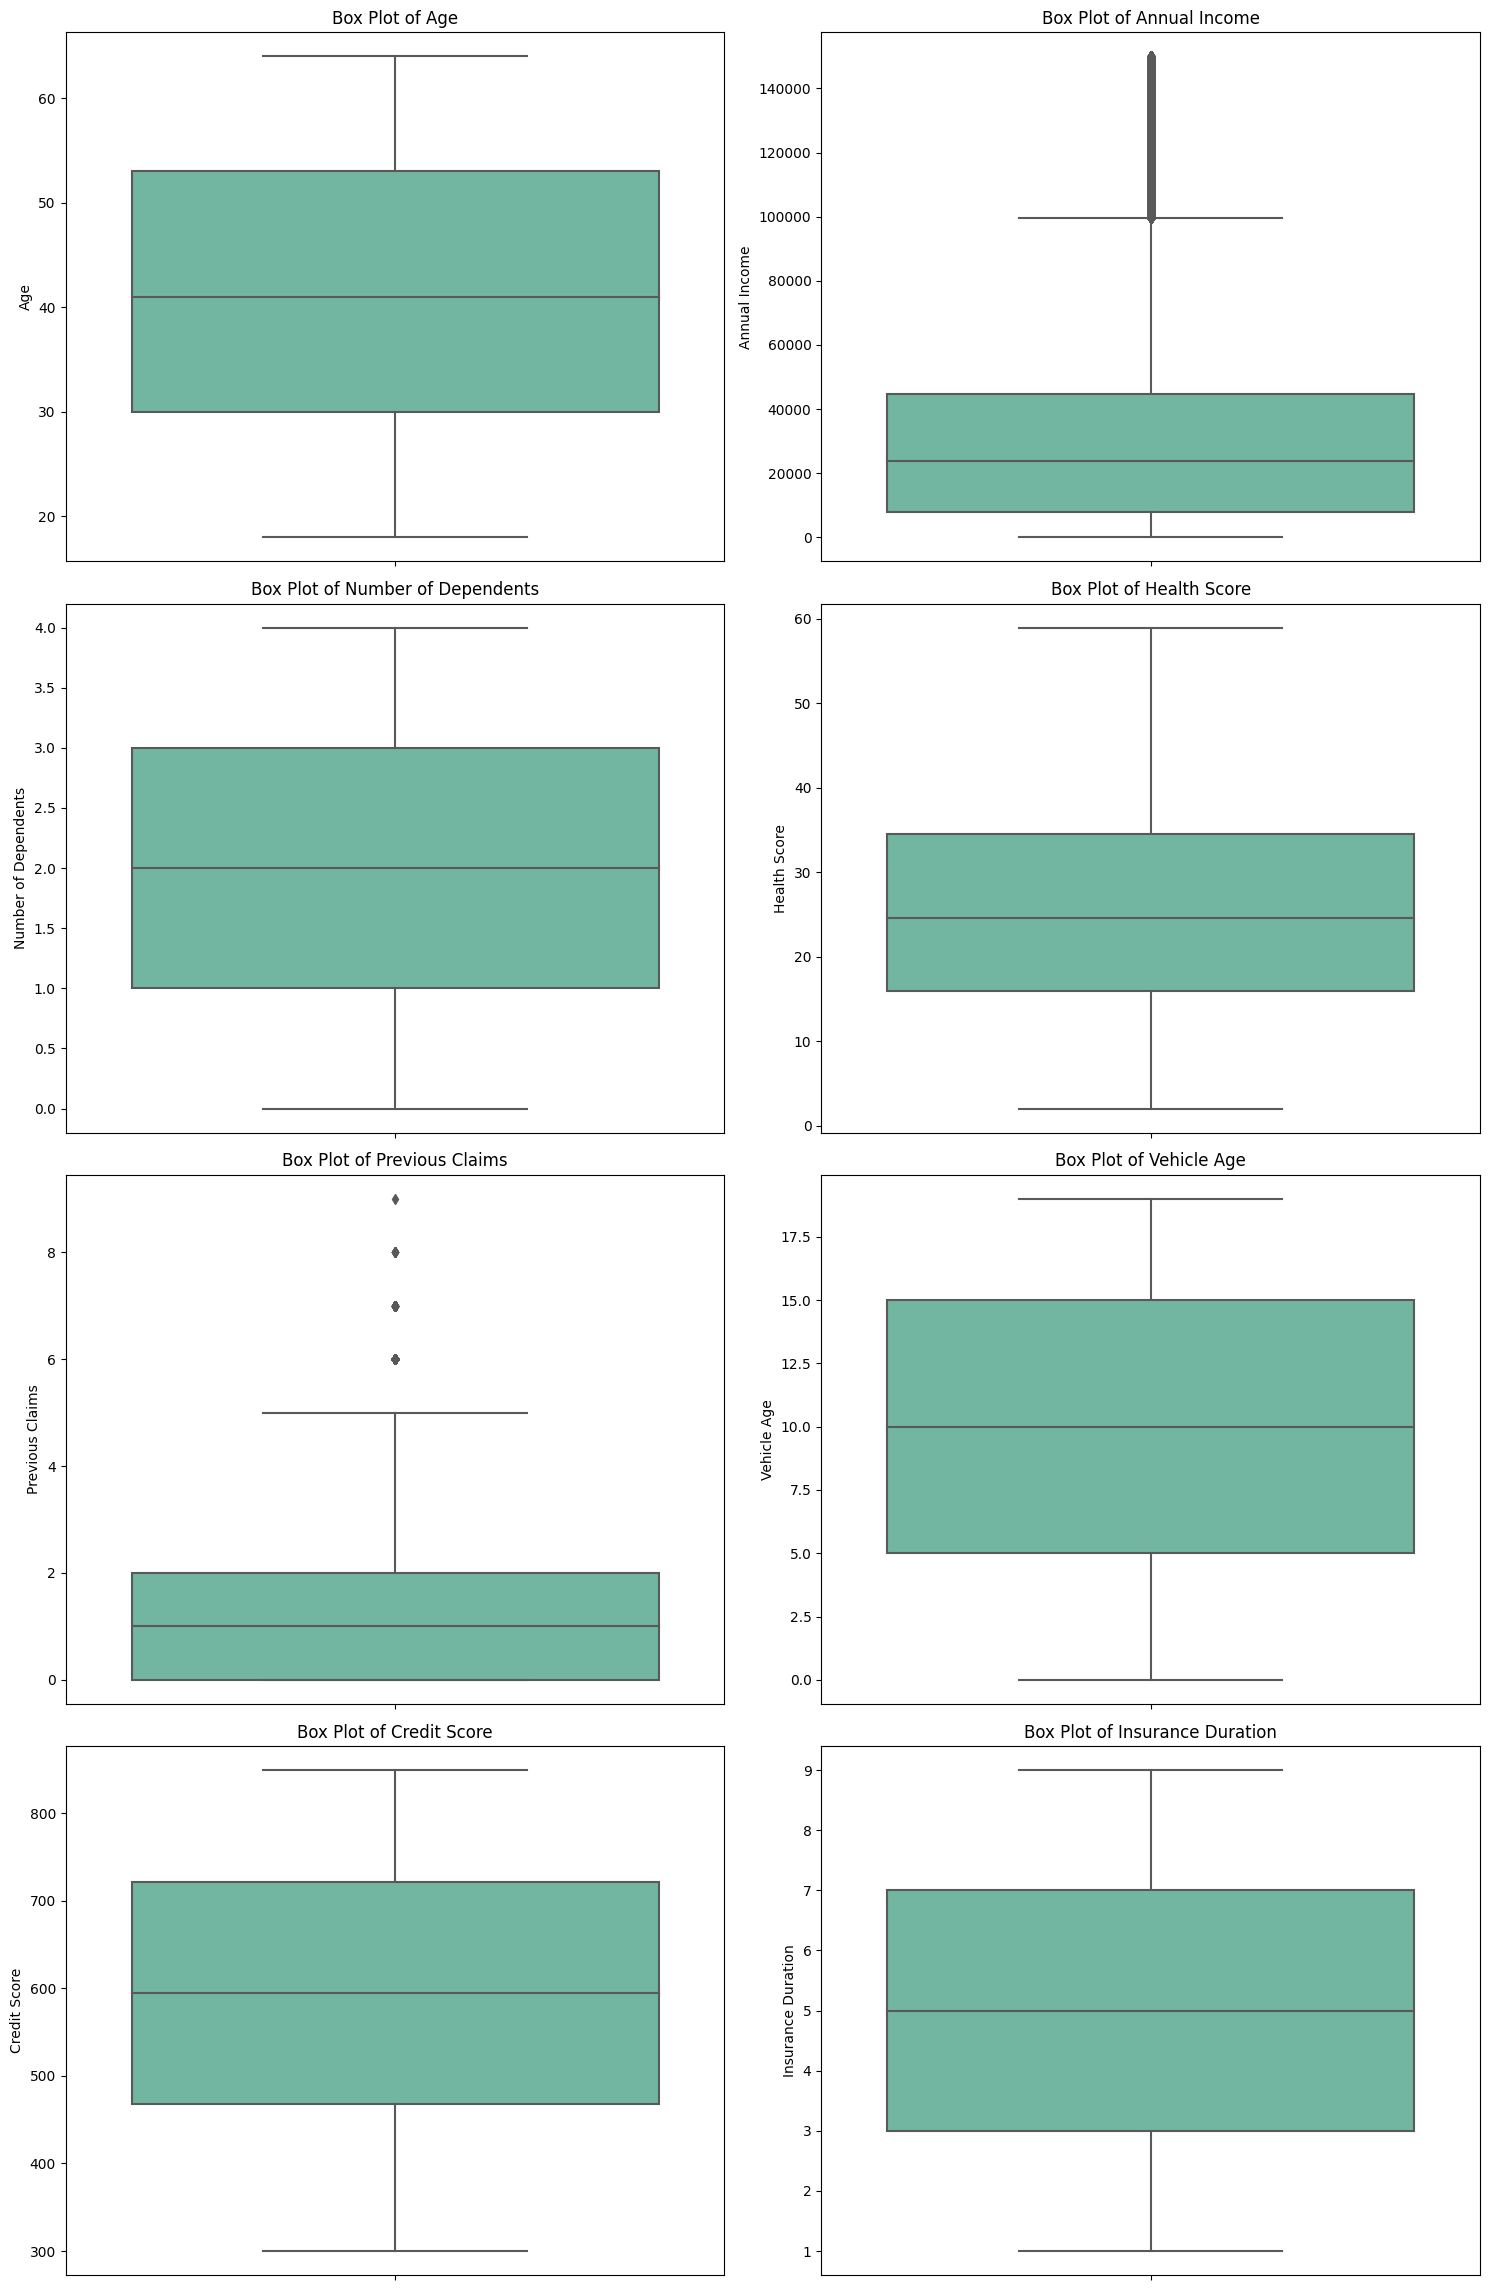

In [23]:
fig, axes = plt.subplots(4, 2, figsize=(15, 23))
axes = axes.flatten() 

for i, column in enumerate(numerical_column):
    sns.boxplot(data=train, y=column, ax=axes[i], palette="Set2")
    axes[i].set_title(f'Box Plot of {column}', fontsize=12)
    axes[i].set_xlabel('')  
    axes[i].set_ylabel(column)

plt.tight_layout()
plt.show()

# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">💼 Policy Types Across Occupations 🚀</p>

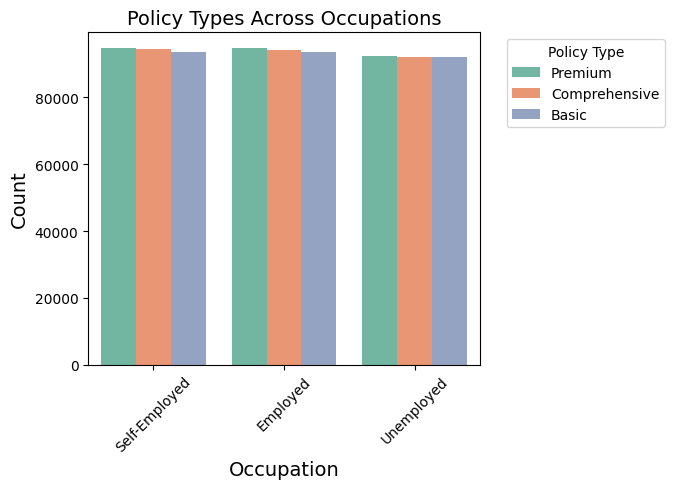

In [24]:
colors = sns.color_palette('Set2', n_colors=3)

plt.figure(figsize=(5, 5))
sns.countplot(x='Occupation', hue='Policy Type', data=train, palette=colors)

plt.title('Policy Types Across Occupations', fontsize=14)
plt.xlabel('Occupation', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.xticks(rotation=45)

plt.tight_layout()

plt.legend(title='Policy Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">💍💔 Policy Type Distribution by Marital Status 💑🔥</p>

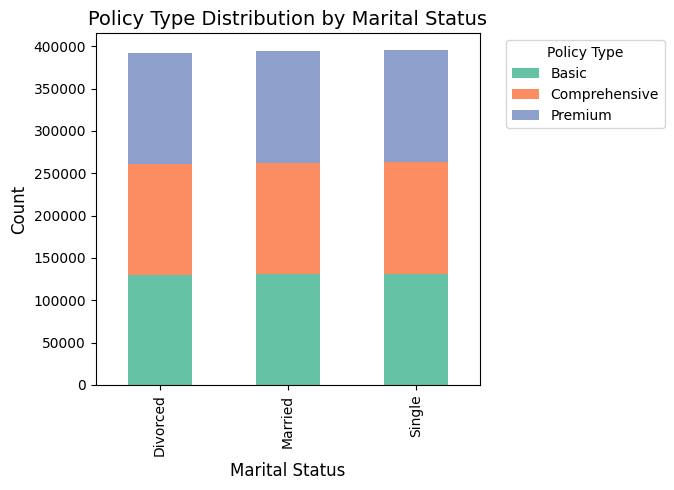

In [25]:
policy_counts = train.groupby(['Marital Status', 'Policy Type']).size().unstack()

ax = policy_counts.plot(kind='bar', stacked=True, figsize=(5, 5), color=colors)

plt.title('Policy Type Distribution by Marital Status', fontsize=14)
plt.xlabel('Marital Status', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()

plt.legend(title='Policy Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">💪🏽🤕 Health vs Claims: The Risky Business! 🤕💪🏽</p>

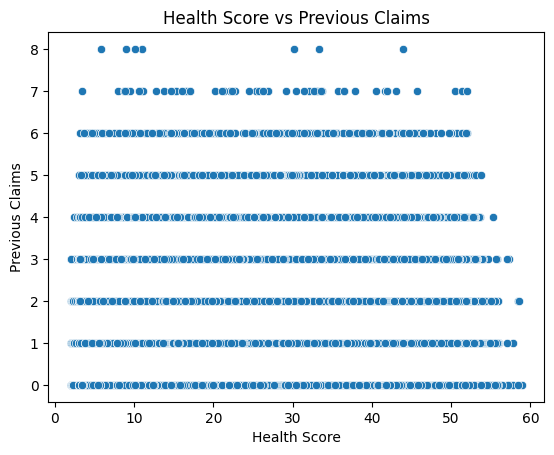

In [26]:
sns.scatterplot(x='Health Score', y='Previous Claims', data=train)
plt.title('Health Score vs Previous Claims')
plt.xlabel('Health Score')
plt.ylabel('Previous Claims')
plt.show()

# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">💸Yearly Chronicles: Unveiling Trends One Date at a Time!📅</p>

In [27]:
print("Insurance start year:",train['Start Year'].min())
print('-'* 50)
print("Insurance ends year:",train['Start Year'].max())

Insurance start year: 2019
--------------------------------------------------
Insurance ends year: 2024


In [28]:
annual_premium = train.pivot_table(index='Start Year', values='Premium Amount', aggfunc='sum').reset_index()
annual_premium['Average Premium'] = annual_premium['Premium Amount'].mean()

annual_premium

,Start Year,Premium Amount,Average Premium
0,2019,100267048.0,2.205090e+08
1,2020,265483829.0,2.205090e+08
2,2021,267780011.0,2.205090e+08
3,2022,268207773.0,2.205090e+08
4,2023,261671929.0,2.205090e+08
5,2024,159643196.0,2.205090e+08


# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">💸 Avg Premium Amount vs Policy Start Year: Trends Unfold! 📅</p>

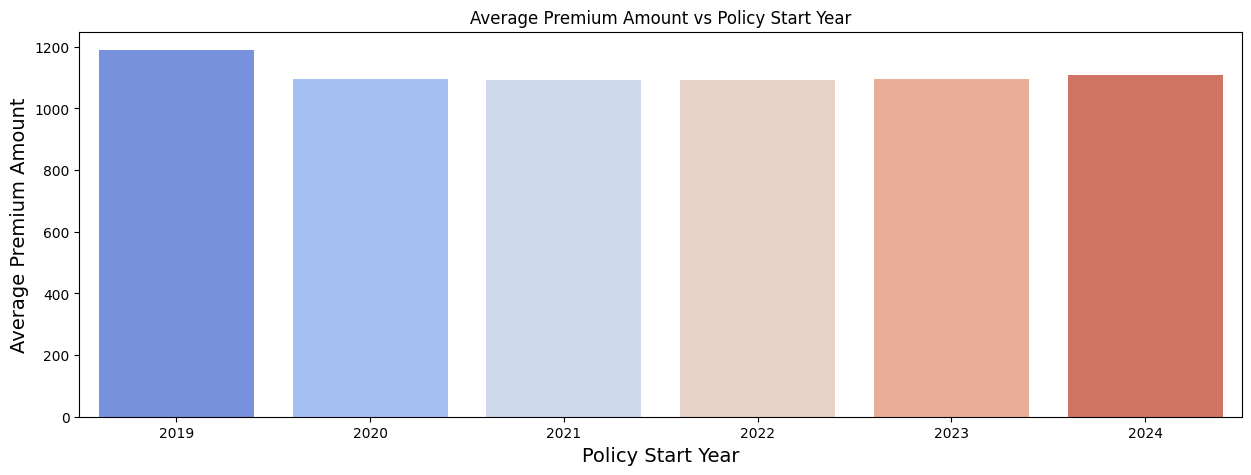

In [29]:
avg_premium = train.groupby('Start Year')['Premium Amount'].mean().reset_index()
plt.figure(figsize=(15, 5))
sns.barplot(x='Start Year', y='Premium Amount', data=avg_premium, palette="coolwarm")

plt.title('Average Premium Amount vs Policy Start Year')
plt.xlabel('Policy Start Year', fontsize=14)
plt.ylabel('Average Premium Amount', fontsize=14)

plt.show()

# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">💧 Premium Amount vs Start Day: Splash of Blue! 📅</p>

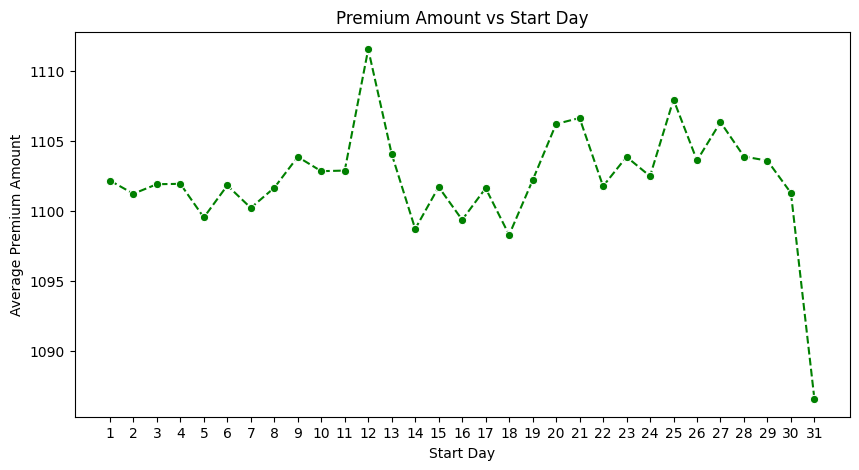

In [30]:
day_premium = train.groupby('Start Day')['Premium Amount'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(x='Start Day', y='Premium Amount', data=day_premium, marker='o', color='green', markersize=6, linestyle='--')

plt.title('Premium Amount vs Start Day', color='black')
plt.xlabel('Start Day', color='black')
plt.ylabel('Average Premium Amount',color='black')
plt.xticks(ticks=range(1, 32))

plt.show()

# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">🎉 Premiums Across the Year: Monthly Thrills!</p>

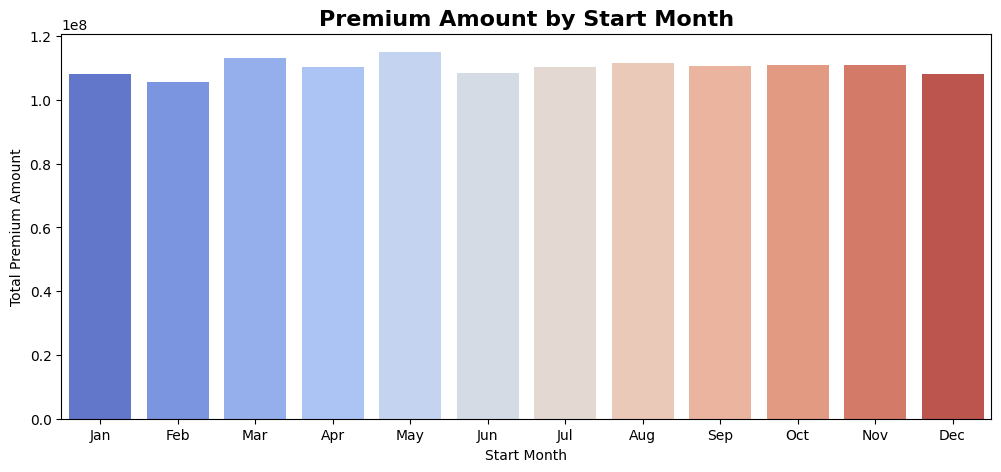

In [31]:
monthly_premium = train.groupby('Start Month')['Premium Amount'].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.barplot(x='Start Month', y='Premium Amount', data=monthly_premium, palette='coolwarm')

plt.title('Premium Amount by Start Month', color='black', fontsize=16, fontweight='bold')
plt.xlabel('Start Month', color='black')
plt.ylabel('Total Premium Amount', color='black')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()

# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">📖 Fun-Filled Null Value Handling</p>

In [32]:
train['Customer Feedback'] = train['Customer Feedback'].fillna(train['Customer Feedback'].mode()[0])
train['Occupation'] = train['Occupation'].fillna(train['Occupation'].mode()[0])
train['Marital Status'] = train['Marital Status'].fillna(train['Marital Status'].mode()[0])

In [33]:
features_list = [
    'Gender',
    'Marital Status',
    'Education Level',
    'Occupation',
    'Location',
    'Policy Type',
    'Customer Feedback',
    'Exercise Frequency',
    'Property Type',
    'Smoking Status'
]

In [34]:
num_features = ['Age', 
                'Annual Income', 
                'Number of Dependents',
                'Health Score',
                'Vehicle Age',
                'Credit Score',
                'Previous Claims',
                'Insurance Duration']

In [35]:
encoders = {feature: LabelEncoder() for feature in features_list}

for feature, encoder in encoders.items():
    train[feature] = encoder.fit_transform(train[feature])

In [36]:
imputer = SimpleImputer(strategy='median')
train[num_features] = imputer.fit_transform(train[num_features])

In [37]:
train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Start Year,Start Month,Start Day
0,0,19.0,0,10049.0,1,1.0,0,1,22.598761,2,...,372.0,5.0,2,0,3,2,2869.0,2023,12,23
1,1,39.0,0,31678.0,0,3.0,2,0,15.569731,0,...,694.0,2.0,0,1,1,2,1483.0,2023,6,12
2,2,23.0,1,25602.0,0,3.0,1,1,47.177549,1,...,595.0,3.0,1,1,3,2,567.0,2023,9,30
3,3,21.0,1,141855.0,1,2.0,0,0,10.938144,0,...,367.0,1.0,2,1,0,0,765.0,2024,6,12
4,4,21.0,1,39651.0,2,1.0,0,1,20.376094,0,...,598.0,4.0,2,1,3,2,2022.0,2021,12,1


# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">🔀 Data Split</p>

In [38]:
X = train.drop(columns=['Premium Amount'])
y = train['Premium Amount']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">📌 Train Model </p>

In [40]:
best_params = {
    'objective': 'mae',  
    'learning_rate': 0.05820157052133642,
    'n_estimators': 97,
    'max_depth': 10,
    'num_leaves': 22,
    'reg_alpha': 0.025041488939909966,  
    'reg_lambda': 0.04398938070361757,   
    'colsample_bytree': 0.513282987217108,  
    'verbose': -1,
    'n_jobs': -1,
    'device': 'gpu'
}

model = lgb.LGBMRegressor(**best_params)

model.fit(X, y)

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


LGBMRegressor(colsample_bytree=0.513282987217108, device='gpu',
              learning_rate=0.05820157052133642, max_depth=10, n_estimators=97,
              n_jobs=-1, num_leaves=22, objective='mae',
              reg_alpha=0.025041488939909966, reg_lambda=0.04398938070361757,
              verbose=-1)

In [41]:
test['Customer Feedback'] = test['Customer Feedback'].fillna(test['Customer Feedback'].mode()[0])
test['Occupation'] = test['Occupation'].fillna(test['Occupation'].mode()[0])
test['Marital Status'] = test['Marital Status'].fillna(test['Marital Status'].mode()[0])
test['Policy Start Date'] = pd.to_datetime(test['Policy Start Date'])
test['Start Year'] = test['Policy Start Date'].dt.year
test['Start Month'] = test['Policy Start Date'].dt.month
test['Start Day'] = test['Policy Start Date'].dt.day
test.drop(columns=['Policy Start Date'], inplace=True)

In [42]:
for feature, encoder in encoders.items():
    test[feature] = encoder.transform(test[feature])

test[num_features] = imputer.transform(test[num_features])

In [43]:
test.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Start Year,Start Month,Start Day
0,1200000,28.0,0,2310.0,2,4.0,0,1,7.657981,0,...,19.0,595.0,1.0,2,1,3,2,2023,6,4
1,1200001,31.0,0,126031.0,1,2.0,2,1,13.381379,1,...,14.0,372.0,8.0,1,1,2,0,2024,4,22
2,1200002,47.0,0,17092.0,0,0.0,3,2,24.354527,2,...,16.0,819.0,9.0,0,1,1,1,2023,4,5
3,1200003,28.0,0,30424.0,0,3.0,3,1,5.136225,1,...,3.0,770.0,5.0,2,1,0,2,2023,10,25
4,1200004,24.0,1,10863.0,0,2.0,1,2,11.844155,1,...,14.0,755.0,7.0,0,0,3,2,2021,11,26


# <p style="background-color: #2D3748; font-family: 'Verdana', sans-serif; font-weight: bold; color: #F7FAFC; font-size: 70%; text-align: center; border: 2px solid #CBD5E0; border-radius: 12px; padding: 12px; box-shadow: 0 6px 18px rgba(0, 0, 0, 0.3);">🚀 Submission Showdown</p>

In [44]:
preds = model.predict(test)
predictions_df = pd.DataFrame(preds, columns=['Premium Amount'])

In [45]:
submission = pd.DataFrame({
    'id': test['id'],  
    'Premium Amount': predictions_df['Premium Amount']
})

In [46]:
print(submission)

             id  Premium Amount
0       1200000      962.915682
1       1200001      846.684459
2       1200002      901.622329
3       1200003      885.780285
4       1200004      863.345826
...         ...             ...
799995  1999995     1043.705711
799996  1999996      806.604541
799997  1999997      938.775995
799998  1999998      927.514814
799999  1999999      838.439873

[800000 rows x 2 columns]


In [47]:
submission.to_csv('submission.csv', index=False)
print("File saved...")

File saved...
